In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import svds
import networkx as nx
from copy import deepcopy
from scipy import linalg
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt

The notebook contains the functions used to deal with multipartite graphs - taken from the work we did with microsoft. 

Generally - the functions will take in and out 2 things: 
- the matrix or the embedding
- attributes: two lists, each a dictionary containing information about the rows/columns respectively. 

would be good if: 
* no time results in no time in partitions 
* can specify a weight column 
* how does it so far relate to LMM data? - check with time series data

In [2]:
# replace with own path to data folder:
# path = 'path_to_data_folder'
# path = '/home/ag16115/Documents/phd/codebase_data/brazil'

In [3]:
from preprocessing import *
from embedding import *
from misc import *

# dynamic - lyon school 

In [11]:
# load data 
# need the activity_data.csv file
path = '/home/ag16115/Documents/phd/codebase_data/'
data = pd.read_csv(path + 'ia-primary-school-proximity-attr.edges', sep = ',', on_bad_lines='skip', header = None)
# data = pd.read_csv(path + '/activity_data.csv', sep = '\t', on_bad_lines='skip')

In [12]:
## rename columns   
data.columns = ['V1', 'V2', 'T', 'L1', 'L2']
## sort out time column
data['H'] = [int(int(t)/(60*60)) for t in list(data['T'])]
data['D'] = [int(int(t)/(60*60*24)) for t in list(data['T'])]
data['T1'] = [10*int(i/24) + i%24 - 8 for i in list(data['H'])]

In [13]:
def scree_plot(A, s = 1, vline=None):
    UA, SA, VAt = scipy.sparse.linalg.svds(A,k=50)
    SA = SA[::-1]

In [14]:
def scree_plot(A, k = 50, s = 10, vline=None):
    UA, SA, VAt = scipy.sparse.linalg.svds(A,k=k)
    fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(range(len(SA)), np.sort(SA)[::-1], s =s)
    if vline:
        plt.axvline(x=vline, color='green', linewidth=0.5)
        
# def subspace_scree_plots(embeddings, s = 1, vlines=None):
#     fig, axs = plt.subplots(len(embeddings), figsize=(12,4*len(embeddings)))
#     fig.patch.set_facecolor('white')
#     for i, p in enumerate(embeddings.keys()):
#         axs[i].title.set_text(p)
#         axs[i].scatter(range(len(embeddings[p].metadata['partition singular values'])), np.sort(embeddings[p].metadata['partition singular values'])[::-1], s =s)
#         if vlines:
#             axs[i].axvline(x=vlines[i], color='green', linewidth=0.5)

In [15]:
A, attributes = matrix_from_tables(data, ['V1','V2'], dynamic_col='T', join_token='::')

['V1', 'V2']


In [16]:
A 

<242x750200 sparse matrix of type '<class 'numpy.float64'>'
	with 251546 stored elements in Compressed Sparse Row format>

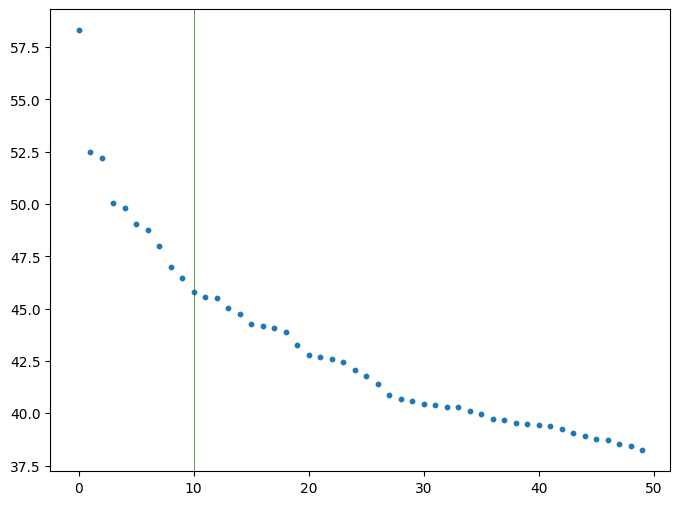

In [17]:
d = 10
scree_plot(A, k = 50,s = d, vline=10)

In [18]:
d = 10
embedding = embed(A, d = d, matrix = 'adjacency', regulariser = 0)
LHS = embedding[0]  
RHS = embedding[1]  

LHS = degree_correction(LHS)      
RHS = degree_correction(RHS)  


/home/ag16115/Documents/phd/codebase/embedding.py:170: UserWarning: Warning: More than one connected component in the graph.
  warnings.warn(


In [19]:
RHS.shape

(750200, 10)

In [20]:
LHS.shape

(242, 10)

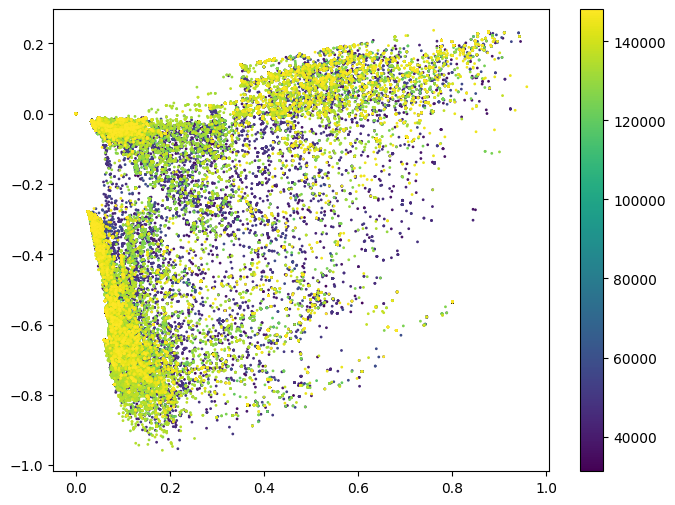

In [21]:
## plot the right hand side embedding and colour by time    
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')   
plt.scatter(RHS[:,0], RHS[:,1], c = [att['time'] for att in attributes[1]], s = 1, cmap = 'viridis')    
plt.colorbar()
plt.show()
    


# multipartite - brazil

The data contains information about the procurement process in Brazil. Each row contains information about a tender with information:
- Tender: tender id
- Period: time 
- Buyer: who is funding
- Item: what the tender is abour 
- Company: who has bid for the tender
- bidder_win: whether the bid was won or not

In [22]:
data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')
A, attributes = matrix_from_tables(data, [['Company', 'Tender'], ['Company', 'Buyer'],['Company', 'Item']],dynamic_col = 'Period', join_token='::')

/tmp/ipykernel_8113/558244675.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path + 'brazil/activity_data.csv', sep = '\t', on_bad_lines='skip')


['Company', 'Tender']
['Company', 'Buyer']
['Company', 'Item']


In [23]:
# find subgraph wanted

subgraph_attributes = [
    [{'partition': 'Company'},{'partition': 'Tender'}],
    {'partition': 'Buyer'}
]

# subgraph_attributes = [
#     {'partition': 'Company'},
#     {'partition': 'Buyer'}
# ]
subgraph_A, subgraph_attributes  = find_subgraph(A, attributes,subgraph_attributes)

In [24]:
# A_dilation = symmetric_dilation(subgraph_A)
# is_symmetric(A_dilation)

In [25]:
# take the largest connected component
cc_A, cc_attributes = find_connected_components(A, attributes,n_components = 1)

In [26]:
cc_A.shape

(17311, 58791)

In [27]:
d = 10
embedding = embed(A, d=d, matrix='adjacency', regulariser=0)

/home/ag16115/Documents/phd/codebase/embedding.py:170: UserWarning: Warning: More than one connected component in the graph.
  warnings.warn(


# toy data

In [86]:
df = pd.DataFrame(
    {'A': ['a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a2', 'a2'],
        'B': ['b1', 'b2', 'b1', 'b2', 'b1', 'b2', 'b1', 'b2'],
        'ID': [1, 1, 1, 1, 2, 2, 2, 2]})
relationships = ['A', 'B']
time_col = 'ID'
A1, attributes1 = matrix_from_tables(
    df, relationships, dynamic_col=time_col, join_token='::')

c0, att0 = find_cc_containing_most(A1, attributes1, 'B', dynamic=False)
c1, att1 = find_cc_containing_most(A1, attributes1, 'A', dynamic=True)

['A', 'B']
Number of connected components: 2
Number of connected components: 2


# weighted - harry potter 

## needs to be incorporated

In [78]:
def make_adjacency_matrix(n, source, target, weight=None):
    """ 
    Make adjacency matrix from source and target arrays.    
    """

    if weight is None:
        weights = np.ones(len(n))
    else:
        weights = weight
    A1 = sparse.coo_matrix((weights, (source, target)), shape=(n, n))
    A2 = sparse.coo_matrix((weights, (target, source)), shape=(n, n))
    return A1 + A2

In [79]:
# find unique elements of a list
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [80]:
path = '/home/ag16115/Documents/phd/codebase_data'
data = pd.read_csv(path + '/harry_potter.csv', sep=',')
attributes = pd.read_csv(path + '/HP-characters.csv', sep=',')

In [ ]:
present_ids = sorted(
    unique(union(data['source'].unique(), data['target'].unique())))
attributes = attributes[attributes['id'].isin(
    present_ids)].reset_index(drop=True)
nodes = list(attributes['name'])
n = len(nodes)
id_to_node = dict(zip(range(len(nodes)), nodes))

# replace '-' on type column to -1
data = data.replace('-', -1)
data = data.replace('+', 1)

A = make_adjacency_matrix(n, data['source'], data['target'], data['type'])

In [87]:
attributes1

[[{'name': 'A::a1', 'partition': 'A', 'time': nan},
  {'name': 'A::a2', 'partition': 'A', 'time': nan},
  {'name': 'B::b1', 'partition': 'B', 'time': nan},
  {'name': 'B::b2', 'partition': 'B', 'time': nan}],
 [{'name': 'A::a1', 'partition': 'A', 'time': 1},
  {'name': 'A::a2', 'partition': 'A', 'time': 1},
  {'name': 'B::b1', 'partition': 'B', 'time': 1},
  {'name': 'B::b2', 'partition': 'B', 'time': 1},
  {'name': 'A::a1', 'partition': 'A', 'time': 2},
  {'name': 'A::a2', 'partition': 'A', 'time': 2},
  {'name': 'B::b1', 'partition': 'B', 'time': 2},
  {'name': 'B::b2', 'partition': 'B', 'time': 2}]]

# time series

In [81]:
data = pd.read_csv(path + '/sp500_data.csv', sep=',')

In [104]:
def matrix_from_time_series(data, time_col, drop_nas = True):
    data = data.sort_values(by=time_col)
    data = data.dropna(axis=1, how='any')

    times = list(data[time_col])
    data.drop([time_col], axis=1, inplace=True)
    ids = list(data.columns)

    Y = np.array(data).T
    attributes = [
        [{'name': i} for i in ids], [{'time': i} for i in times]
    ]
    return Y, attributes

In [107]:
Y, attributes = matrix_from_time_series(data, 'date')

# text analysis

In [ ]:

from textblob import Word
from nltk.corpus import stopwords
import nltk
import re
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

In [ ]:
def pc_scores(X, r):
    U, s, Vh = svds(X, k=r)
    idx = s.argsort()[::-1]
    Vh = Vh[idx, :]
    Y = X @ Vh.T
    return Y

In [110]:
df

,data,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [111]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()  # remove=('headers', 'footers', 'quotes')
# # pprint(list(newsgroups.target_names))

# create dataframe from newsgroup data
df = pd.DataFrame()
df["data"] = newsgroups["data"]

the rest is not finished: 

In [ ]:
def matrix_from_text(data, column_name, remove_stopwords=False, clean_text = True, remove_email_addresses = False):
    """
    Create a matrix from a column of text data.
    """

    ## gets rid of email addresses  in data
    if remove_email_addresses:
        df["data_str"] = df.data.apply(lambda row: del_email_address(row))
`# gets rid of stopwords, symbols, makes lower case and base words
    if remove_stopwords:
        df["data_str"] = df.data_str.apply(lambda row: remove_stopwords(row))
df["data_str"] = df.data_str.apply(lambda row: clean_text(row))
   
    # create tfidf matrix
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data[column_name])
    return X, data`

def del_email_address(text):
    e = '\S*@\S*\s?'
    pattern = re.compile(e)
    return pattern.sub('', text) 

def clean_text(text):
    return " ".join([ Word(word).lemmatize() for word in re.sub("[^A-Za-z0-9]+", " ", text).lower().split()])  

In [ ]:
newsgroups = fetch_20newsgroups()  # remove=('headers', 'footers', 'quotes')
# # pprint(list(newsgroups.target_names))

# create dataframe from newsgroup data
df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(
    lambda row: newsgroups["target_names"][row])
df[['layer1', 'layer2']] = df['target_names'].str.split('.', 1, expand=True)

# ## use random sample of data
n = 5000
df = df.sample(n=n, replace=False, random_state=22).reset_index(drop=True)

n = len(df)

# list of common words to delete
stopword = set(nltk.corpus.stopwords.words("english"))
stopword.update(['subject'])

# gets rid of email addresses  in data
df["data_str"] = df.data.apply(lambda row: del_email_address(row))
# gets rid of stopwords, symbols, makes lower case and base words
df["data_str"] = df.data_str.apply(lambda row: clean_text(row))

# vectorize data
vectorizer = TfidfVectorizer(min_df=5, max_df=n-1000)
Y = vectorizer.fit_transform(df.data_str)